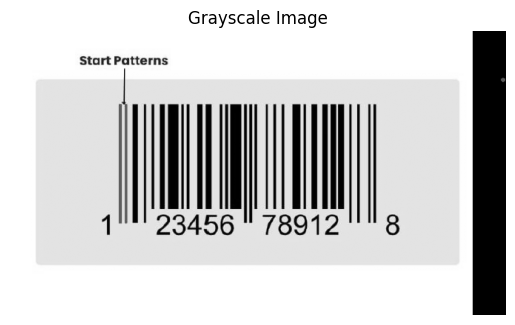

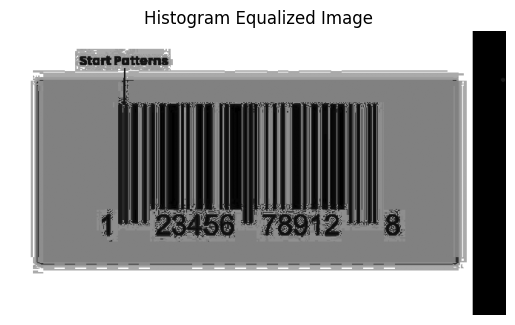

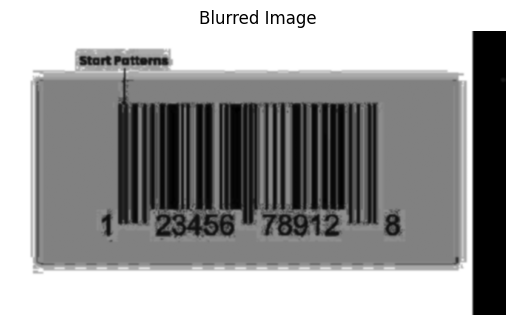

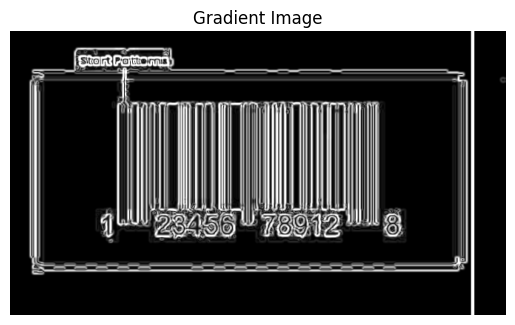

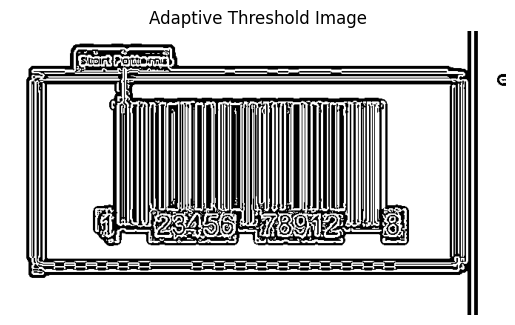

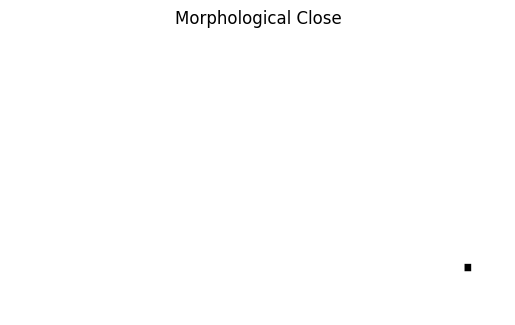

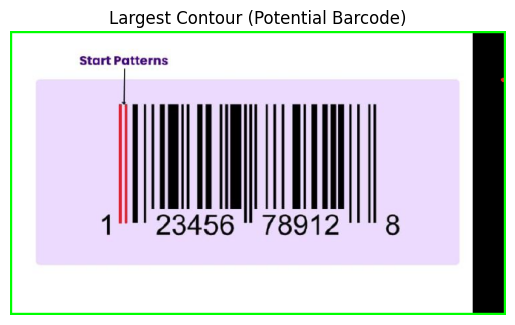

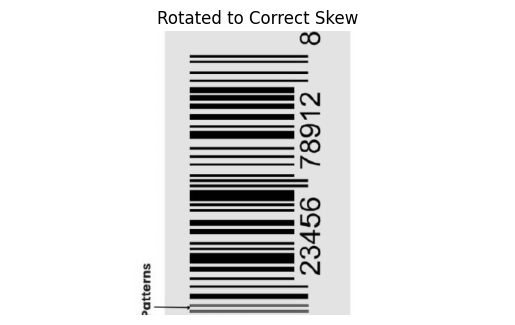

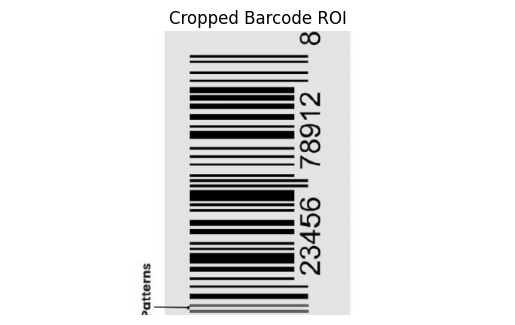

Type    : EAN13
Data    : 0123456789128
Bounding Box : Rect(left=243, top=33, width=140, height=347)


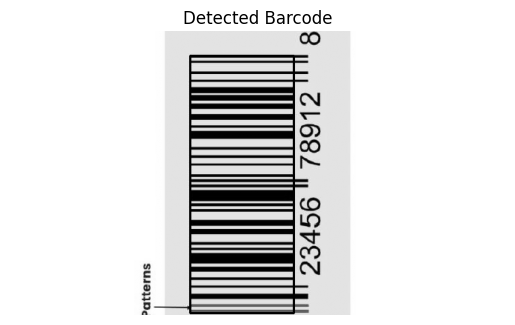

In [14]:
import cv2
import numpy as np
from matplotlib import pyplot as plt
from pyzbar.pyzbar import decode

def display(title, image, cmap='gray'):
    """A helper function to display an image with a title."""
    plt.imshow(image, cmap=cmap)
    plt.title(title)
    plt.axis('off')
    plt.show()

# Load Image
image = cv2.imread(r"barcod.png")
if image is None:
    raise IOError("Could not open the image. Check the path or image format.")

# Convert to grayscale
gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
display("Grayscale Image", gray)

# Contrast Enhancement using Histogram Equalization
equalized = cv2.equalizeHist(gray)
display("Histogram Equalized Image", equalized)

# Apply Gaussian Blur to reduce noise
blurred = cv2.GaussianBlur(equalized, (5, 5), 0)
display("Blurred Image", blurred)

# Edge Detection using Sobel Operator
grad_x = cv2.Sobel(blurred, cv2.CV_32F, 1, 0, ksize=3)
grad_y = cv2.Sobel(blurred, cv2.CV_32F, 0, 1, ksize=3)
gradient = cv2.magnitude(grad_x, grad_y)
gradient = cv2.convertScaleAbs(gradient)
display("Gradient Image", gradient)

# Adaptive Thresholding
adaptive_thresh = cv2.adaptiveThreshold(
    gradient, 
    255, 
    cv2.ADAPTIVE_THRESH_GAUSSIAN_C, 
    cv2.THRESH_BINARY, 
    11, 
    2
)
display("Adaptive Threshold Image", adaptive_thresh)

# Morphological Processing to Enhance Barcode
kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (9, 9))
morphed = cv2.morphologyEx(adaptive_thresh, cv2.MORPH_CLOSE, kernel)
display("Morphological Close", morphed)

# Contour Detection
contours, _ = cv2.findContours(morphed, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
if not contours:
    print("No contours found. Cannot detect a barcode.")
    exit()

contours = sorted(contours, key=cv2.contourArea, reverse=True)
for contour in contours:
    if cv2.contourArea(contour) > 1000:
        largest_contour = contour
        break
else:
    print("No valid barcode-sized contour found.")
    exit()

peri = cv2.arcLength(largest_contour, True)
approx = cv2.approxPolyDP(largest_contour, 0.02 * peri, True)
drawn_contours = image.copy()
cv2.drawContours(drawn_contours, [approx], -1, (0, 255, 0), 3)
display("Largest Contour (Potential Barcode)", cv2.cvtColor(drawn_contours, cv2.COLOR_BGR2RGB), cmap=None)

# Skew/Orientation Correction
rect = cv2.minAreaRect(largest_contour)
box = cv2.boxPoints(rect)
box = box.astype(int)
angle = rect[-1]
if angle < -45:
    angle += 90
(h, w) = gray.shape[:2]
center = (w // 2, h // 2)
M = cv2.getRotationMatrix2D(center, angle, 1.0)
rotated = cv2.warpAffine(gray, M, (w, h), flags=cv2.INTER_CUBIC, borderMode=cv2.BORDER_REPLICATE)
display("Rotated to Correct Skew", rotated)

# Extract/Crop the Barcode ROI
rotated_blurred = cv2.GaussianBlur(rotated, (5, 5), 0)
_, rotated_thresh = cv2.threshold(rotated_blurred, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)
rot_contours, _ = cv2.findContours(rotated_thresh, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
if not rot_contours:
    print("No contours found in rotated image.")
    exit()
largest_rot_contour = max(rot_contours, key=cv2.contourArea)
x, y, w, h = cv2.boundingRect(largest_rot_contour)
barcode_roi = rotated[y:y+h, x:x+w]
display("Cropped Barcode ROI", barcode_roi)

# Decode the Barcode
decoded_objects = decode(barcode_roi)
if not decoded_objects:
    print("No barcode detected or could not decode.")
else:
    for obj in decoded_objects:
        barcode_data = obj.data.decode("utf-8").strip()
        print("============================================")
        print(f"Type    : {obj.type}")
        print(f"Data    : {barcode_data}")
        print(f"Bounding Box : {obj.rect}")
        print("============================================")

        # Display detected barcode region
        cv2.rectangle(barcode_roi, (obj.rect.left, obj.rect.top),
                      (obj.rect.left + obj.rect.width, obj.rect.top + obj.rect.height),
                      (0, 255, 0), 2)
        display("Detected Barcode", barcode_roi)